# **1. Machine Learning Deployment for MNIST Dataset**

## **1.1 Convolutional Neural Network for MNIST Dataset**

### **1.1.1 Load and Normalize MNIST Dataset**

In [1]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 90.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import onnx
import torch.onnx

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to tensor
    transforms.Normalize((0.0,), (1.0,))  # Normalize pixels to 0-1
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 117MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 21.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 90.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.47MB/s]


### **1.1.2 Dividing the dataset into training and test set**

In [4]:
train_size = int(0.67 * len(mnist_data))
test_size = len(mnist_data) - train_size
train_data, test_data = random_split(mnist_data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### **1.1.3 Implementing CNN model**

In [5]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))  # 28->26
        x = self.pool1(x)              # 26->13
        x = torch.relu(self.conv2(x))  # 13->11
        x = self.pool2(x)              # 11->5
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### **1.1.4 Compiling and Training the model**

In [6]:
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 391.8843
Epoch 2, Loss: 150.6327
Epoch 3, Loss: 111.6623
Epoch 4, Loss: 96.3595
Epoch 5, Loss: 78.1042


### **1.1.5 Implementing Learning rate scheduling**

In [8]:
# Recreate the model
model = MNIST_CNN()
criterion = nn.CrossEntropyLoss()

# Initial learning rate
lr = 0.001

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Create optimizer with current learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    total_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Learning Rate: {lr:.6f}")
    # Reduce learning rate by 10%
    lr = lr * 0.9

Epoch [1/50], Loss: 354.6176, Learning Rate: 0.001000
Epoch [2/50], Loss: 126.9343, Learning Rate: 0.000900
Epoch [3/50], Loss: 88.5674, Learning Rate: 0.000810
Epoch [4/50], Loss: 72.4636, Learning Rate: 0.000729
Epoch [5/50], Loss: 55.0390, Learning Rate: 0.000656
Epoch [6/50], Loss: 45.5342, Learning Rate: 0.000590
Epoch [7/50], Loss: 38.6938, Learning Rate: 0.000531
Epoch [8/50], Loss: 33.1034, Learning Rate: 0.000478
Epoch [9/50], Loss: 27.2990, Learning Rate: 0.000430
Epoch [10/50], Loss: 24.7213, Learning Rate: 0.000387
Epoch [11/50], Loss: 20.4841, Learning Rate: 0.000349
Epoch [12/50], Loss: 17.5415, Learning Rate: 0.000314
Epoch [13/50], Loss: 17.1221, Learning Rate: 0.000282
Epoch [14/50], Loss: 15.4953, Learning Rate: 0.000254
Epoch [15/50], Loss: 14.7315, Learning Rate: 0.000229
Epoch [16/50], Loss: 13.0253, Learning Rate: 0.000206
Epoch [17/50], Loss: 12.2188, Learning Rate: 0.000185
Epoch [18/50], Loss: 10.4764, Learning Rate: 0.000167
Epoch [19/50], Loss: 10.1980, Learn

In [9]:
# converting test dataset to a single tensor
X_test = []
y_test = []

for images, labels in test_loader:
    X_test.append(images)
    y_test.append(labels)

# stacking all the batches into full tensors
X_test_tensor = torch.cat(X_test, dim=0)
y_test_tensor = torch.cat(y_test, dim=0)

# evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9921


### **1.1.6 Saving the model as ONNX format**

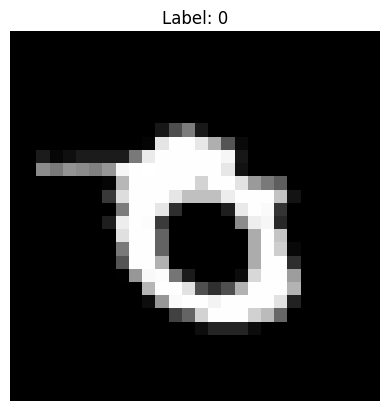

In [10]:
import random

# Pick 5 random indices
random_indices = random.sample(range(len(test_data)), 15)

samples = []

for i, idx in enumerate(random_indices):
    image, label = test_data[idx]
    image_np = image.squeeze().numpy()
    samples.append((image_np, label))
    plt.imshow(image_np, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.savefig(f"sample_{i}.png")

In [11]:
import torch.onnx

# dummy input tensor of the correct shape: (batch_size=1, channels=1, height=28, width=28)
dummy_input = torch.randn(1, 1, 28, 28)

# Export to ONNX format
torch.onnx.export(
    model,                          #trained model
    dummy_input,                    # dummy input for tracing
    "mnist_cnn.onnx",              # output file name
    input_names=['input'],         # input name
    output_names=['output'],       # output name
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},  # optional, but good
    opset_version=11               # ONNX opset version
)

print("Model saved as mnist_cnn.onnx")

Model saved as mnist_cnn.onnx


### **1.1.7 Loading ONNX model**

In [12]:
pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00


In [13]:
import onnxruntime as ort
import numpy as np

# Load ONNX model
session = ort.InferenceSession("mnist_cnn.onnx")

# Pick a sample from the saved images
sample_image, true_label = samples[0]  # Using sample_0.png

# image processing for input
input_tensor = np.expand_dims(np.expand_dims(sample_image, axis=0), axis=0).astype(np.float32)

# Run inference
inputs = {session.get_inputs()[0].name: input_tensor}
outputs = session.run(None, inputs)
logits = outputs[0]

# Get predicted label
predicted_label = np.argmax(logits)

# Print result
print(f"True Label     : {true_label}")
print(f"Predicted Label: {predicted_label}")

True Label     : 1
Predicted Label: 1
